In [111]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib as plt
import pylab as pl
import numpy as np
%pylab inline
import shapely
import pysal as ps
import fiona
import zipfile
import requests
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/Users/mkm/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text', 'inspect', 'plt', 'errorbar', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Reading DOHMH Restauant inspection Data from New York Open Data**

In [112]:
inspect = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results-2.csv')

In [113]:
inspect.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,50054868,COFFEE RX,BROOKLYN,276,88TH ST,11209.0,3477293317,CafÃ©/Coffee/Tea,08/07/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,13.0,A,08/07/2018,12/07/2018,Cycle Inspection / Initial Inspection
1,50036869,PAK LAHORI CHILLI,BROOKLYN,1026,CONEY ISLAND AVE,11230.0,7188591400,Indian,03/27/2018,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,27.0,NaN,NaN,12/07/2018,Cycle Inspection / Initial Inspection
2,40389011,BAGEL CAFE,BRONX,2214,BARTOW AVE,10475.0,7183209011,Delicatessen,11/05/2018,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,30.0,NaN,NaN,12/07/2018,Cycle Inspection / Initial Inspection
3,50034992,EMPANADAS MONUMENTAL,MANHATTAN,550,W 181ST ST,10033.0,6469645773,Spanish,06/08/2017,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,12.0,A,06/08/2017,12/07/2018,Cycle Inspection / Re-inspection
4,40393905,GRANDSTAND TAVERN,QUEENS,8535,GRAND AVENUE,11373.0,7184789633,Irish,07/12/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,19.0,B,07/12/2018,12/07/2018,Cycle Inspection / Re-inspection


In [114]:
#look at the shape of the data
inspect.shape

(383838, 18)

In [115]:
#choose useful columns
inspect = inspect[['BORO','ZIPCODE','CUISINE DESCRIPTION','VIOLATION CODE','CRITICAL FLAG','SCORE','GRADE','INSPECTION DATE' ]]

In [116]:
inspect['GRADE'] = inspect['GRADE'].fillna('N')

In [117]:
inspect.drop_duplicates(inplace=True)
inspect.dropna(inplace=True)

In [118]:
inspect = inspect[inspect['BORO'] != 'Missing']

In [119]:
inspect.shape

(356644, 8)

In [120]:
inspect.head()

,BORO,ZIPCODE,CUISINE DESCRIPTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION DATE
0,BROOKLYN,11209.0,CafÃ©/Coffee/Tea,10F,Not Critical,13.0,A,08/07/2018
1,BROOKLYN,11230.0,Indian,04L,Critical,27.0,N,03/27/2018
2,BRONX,10475.0,Delicatessen,04N,Critical,30.0,N,11/05/2018
3,MANHATTAN,10033.0,Spanish,08A,Not Critical,12.0,A,06/08/2017
4,QUEENS,11373.0,Irish,10B,Not Critical,19.0,B,07/12/2018


**K-mean Clustering: Score against Zipcode**

In [11]:
kinspect = inspect[['ZIPCODE','SCORE']]

In [12]:
kinspect.dropna(inplace=True)

/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
kinspect.head()

,ZIPCODE,SCORE
0,11209.0,13.0
1,11230.0,27.0
2,10475.0,30.0
3,10033.0,12.0
4,11373.0,19.0


In [14]:
#get nyc map
nycshape = gpd.GeoDataFrame.from_file('ZIP_CODE_040114-Copy1.shp')

In [15]:
nycshape.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


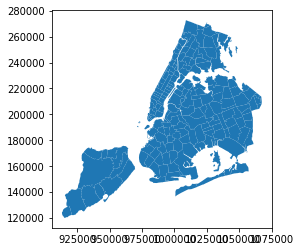

In [16]:
nycshape.plot()

In [17]:
pumashp = gpd.GeoDataFrame.from_file('geo_export_382c76cf-0248-45c5-8c55-63a392461023.shp')

In [18]:
pumashp.crs

{'init': 'epsg:4326'}

Text(0.5, 1.0, 'Map From PUMA shapefile')

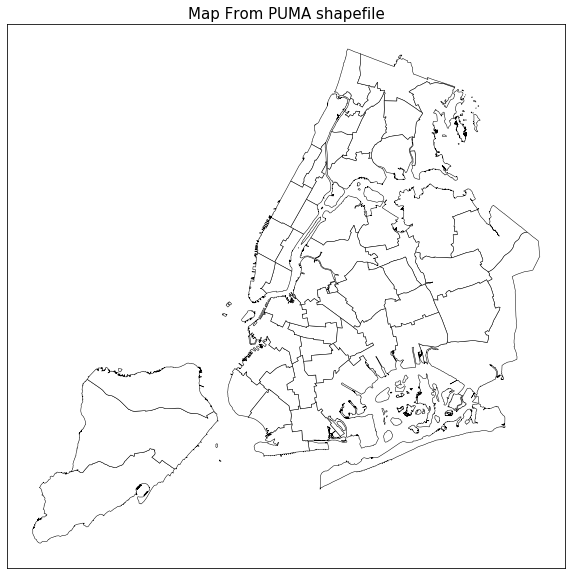

In [19]:
# create a map from PUMA shp
ax = pl.figure(figsize=(10, 10)).add_subplot(111)
pumashp.plot(color="white", edgecolor="black", lw=0.5, ax=ax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pl.title('Map From PUMA shapefile', size = 15)

In [20]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [21]:
man = inspect[inspect['BORO'] == 'MANHATTAN']
bronx = inspect[inspect['BORO'] == 'BRONX']
queens = inspect[inspect['BORO'] == 'QUEENS']
brook = inspect[inspect['BORO'] == 'BROOKLYN']
staten = inspect[inspect['BORO'] == 'STATEN ISLAND']

In [22]:
man.count() / inspect['BORO'].count()

BORO                   0.395128
ZIPCODE                0.395128
CUISINE DESCRIPTION    0.395128
VIOLATION CODE         0.395128
CRITICAL FLAG          0.395128
SCORE                  0.395128
GRADE                  0.395128
INSPECTION DATE        0.395128
dtype: float64

**Exploratory Analysis**

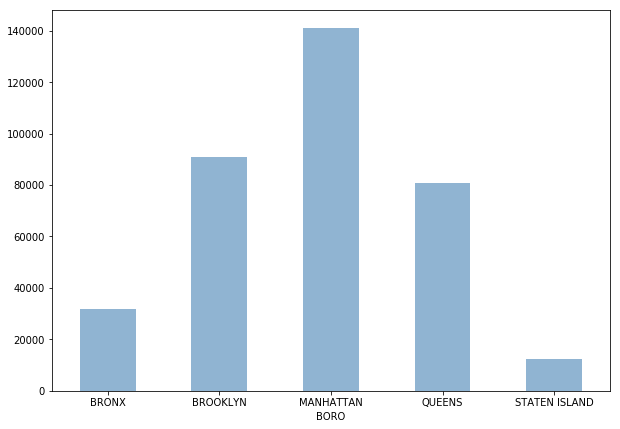

In [23]:
#Number of restuants in each Boro
fig, ax = plt.subplots(figsize = (10,7))
((inspect['BORO'].groupby(inspect['BORO']).count())).plot(ax=ax, kind='bar', color='SteelBlue', alpha = 0.6, rot=0)

In [24]:
cuisine = inspect['BORO'].groupby(inspect['CUISINE DESCRIPTION']).count().sort_values(ascending=False) 
cuisine = cuisine.to_frame()

In [25]:
cuisine.rename(columns = {"BORO":"Count"}, inplace=True)

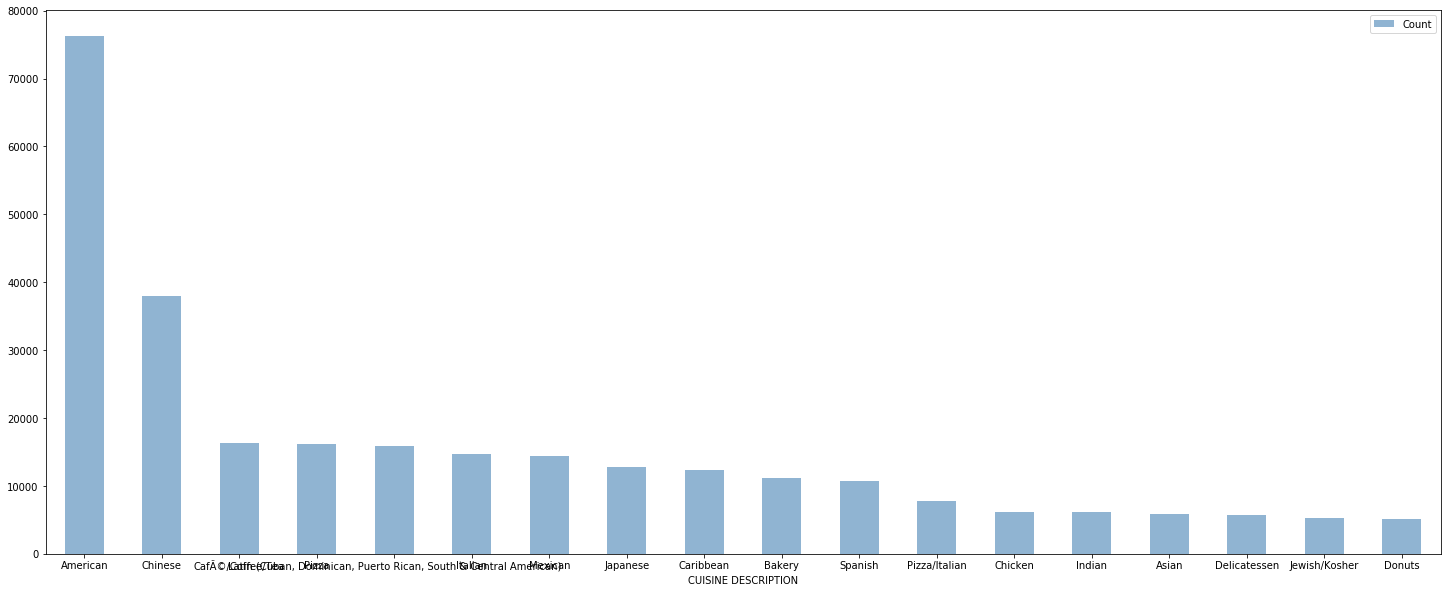

In [26]:
#Number of restuarants in each cuisine
fig, ax = plt.subplots(figsize = (25,10))
cuisine[cuisine['Count']>5000].plot(ax=ax, kind='bar', color='SteelBlue', alpha = 0.6, rot=0)

In [27]:
(cuisine.iloc[:10] / cuisine.sum()).sum()

Count    0.639273
dtype: float64

In [28]:
inspect['SCORE'].groupby(inspect['CUISINE DESCRIPTION']).mean().sort_values()

CUISINE DESCRIPTION
Basque                                                               5.666667
Nuts/Confectionary                                                   7.294118
Fruits/Vegetables                                                   13.540541
Donuts                                                              13.840170
Hotdogs                                                             14.530364
Portuguese                                                          14.605839
Sandwiches                                                          15.287753
English                                                             15.782407
Hamburgers                                                          15.810424
Pancakes/Waffles                                                    15.895349
Soups                                                               15.909091
Czech                                                               15.941176
Ice Cream, Gelato, Yogurt, Ices             

In [29]:
#0 -13 points: A, 14 - 27 points: B , 28+: C
inspect['SCORE'].groupby(inspect['BORO']).mean().sort_values()

BORO
BRONX            19.067142
QUEENS           19.347957
MANHATTAN        19.700823
STATEN ISLAND    19.703791
BROOKLYN         20.078142
Name: SCORE, dtype: float64

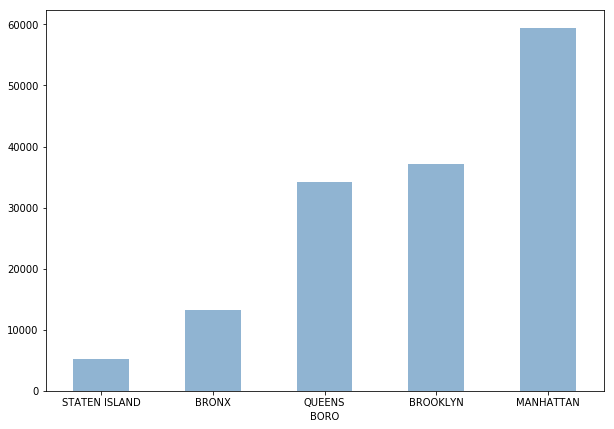

In [30]:
fig, ax = plt.subplots(figsize = (10,7))
inspect['BORO'][inspect['GRADE'] == 'A'].groupby(inspect['BORO']).count().sort_values().plot(ax=ax, kind='bar', 
                                                                                             color='SteelBlue', 
                                                                                             alpha = 0.6,
                                                                                            rot=0)

In [31]:
y1 = inspect['BORO'][inspect['GRADE'] == 'A'].groupby(inspect['BORO']).count()
y2 = inspect['BORO'][inspect['GRADE'] == 'B'].groupby(inspect['BORO']).count()
y3 = inspect['BORO'][inspect['GRADE'] == 'C'].groupby(inspect['BORO']).count()
y4 = inspect['BORO'][inspect['GRADE'] == 'P'].groupby(inspect['BORO']).count()

In [32]:
y1 = y1.to_frame().T
y2 = y2.to_frame().T
y3 = y3.to_frame().T
y4 = y4.to_frame().T

In [33]:
y1.index.names = ['Grade']
y1.rename(index={'BORO': 'A'}, inplace=True)

In [34]:
y2.index.names = ['Grade']
y2.rename(index={'BORO': 'B'}, inplace=True)
y3.index.names = ['Grade']
y3.rename(index={'BORO': 'C'}, inplace=True)

In [35]:
frames = [y1, y2, y3]

In [36]:
grade = pd.concat(frames)

In [37]:
errorbar = np.sqrt(grade)

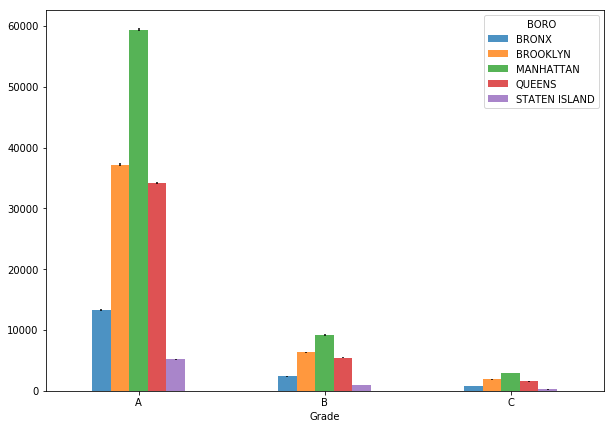

In [38]:
fig, ax = plt.subplots(figsize = (10,7))
grade.plot.bar(ax=ax, alpha = 0.8, rot=0, yerr = errorbar)

Text(0.5, 1.0, 'Number of Restaurants with Different Grades in Each Boro')

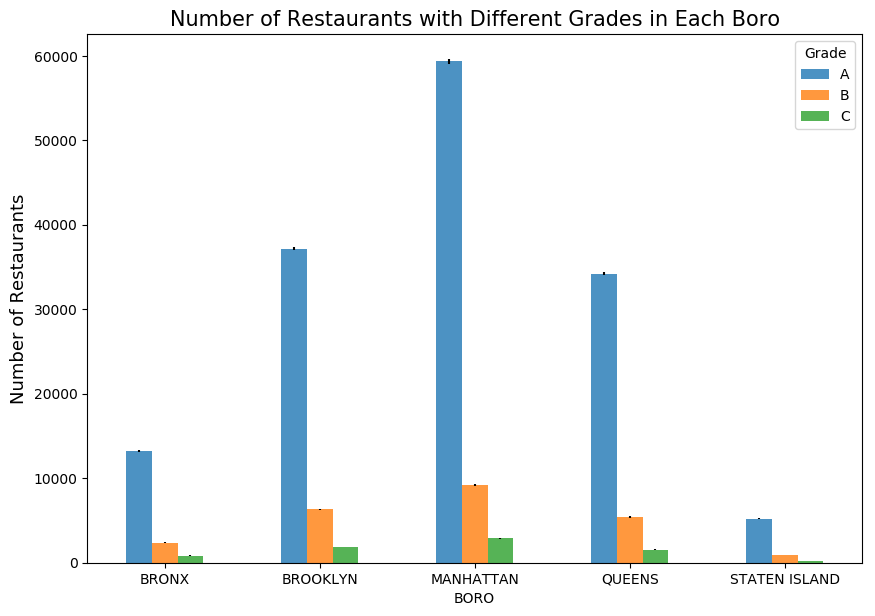

In [39]:
#Number of resturants in each grade for each Boro
fig, ax = plt.subplots(figsize = (10,7), dpi=100)
grade.T.plot.bar(ax=ax, alpha = 0.8, rot=0, yerr=errorbar.T)
plt.ylabel('Number of Restaurants', size=13)
plt.title('Number of Restaurants with Different Grades in Each Boro', size=15)

In [40]:
percBORO = grade / grade.sum()

Text(0.5, 1.0, 'Percentage of Restaurants with Different Grades in Each Boro')

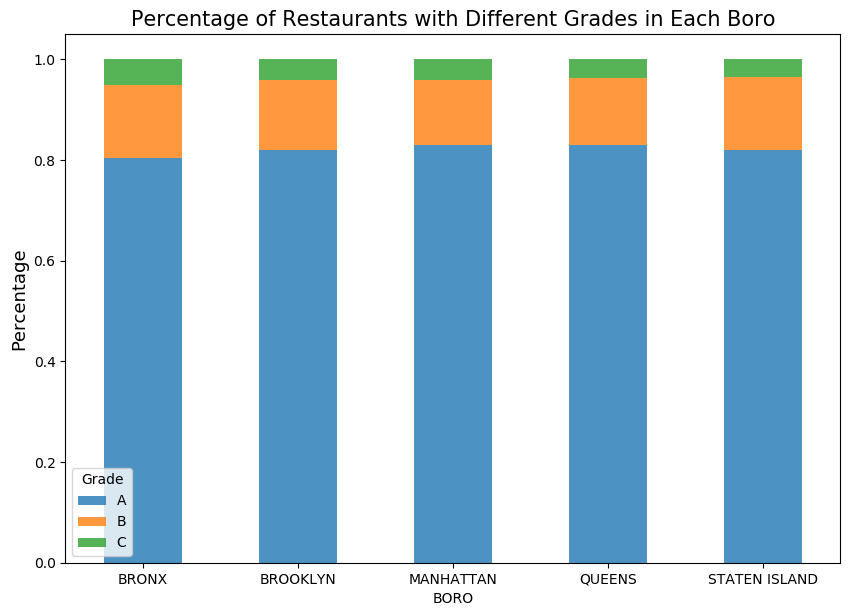

In [41]:
#Number of resturants in each grade for each Boro
fig, ax = plt.subplots(figsize = (10,7), dpi=100)
percBORO.T.plot.bar(ax=ax, alpha = 0.8, rot=0, stacked =True)

plt.ylabel('Percentage', size=13)
plt.title('Percentage of Restaurants with Different Grades in Each Boro', size=15)

**Figure:**
Manhattan has the highest number of resturants among all five boroughs. The portion of grade A resturants is  significantly larger than other grades, thus the overal hygine quality in New York City is good.

In [42]:
c1 = inspect['CUISINE DESCRIPTION'][inspect['GRADE'] == 'A'].groupby(inspect['CUISINE DESCRIPTION']).count()
c2 = inspect['CUISINE DESCRIPTION'][inspect['GRADE'] == 'B'].groupby(inspect['CUISINE DESCRIPTION']).count()
c3 = inspect['CUISINE DESCRIPTION'][inspect['GRADE'] == 'C'].groupby(inspect['CUISINE DESCRIPTION']).count()

In [43]:
c1 = c1.to_frame().T
c2 = c2.to_frame().T
c3 = c3.to_frame().T

In [44]:
c1

CUISINE DESCRIPTION,Afghan,African,American,Armenian,Asian,Australian,Bagels/Pretzels,Bakery,Bangladeshi,Barbecue,...,Soups & Sandwiches,Southwestern,Spanish,Steak,Tapas,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese/Cambodian/Malaysia
CUISINE DESCRIPTION,79,373,34970,149,2134,137,1242,4642,231,285,...,260,24,3508,562,191,836,1709,365,634,551


In [45]:
c1.index.names = ['Grade']
c1.rename(index={'CUISINE DESCRIPTION': 'A'}, inplace=True)
c2.index.names = ['Grade']
c2.rename(index={'CUISINE DESCRIPTION': 'B'}, inplace=True)
c3.index.names = ['Grade']
c3.rename(index={'CUISINE DESCRIPTION': 'C'}, inplace=True)

In [46]:
frames=[c1,c2,c3]
cuisinegrade = pd.concat(frames)
cuisinegrade.head()

/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Afghan,African,American,Armenian,Asian,Australian,Bagels/Pretzels,Bakery,Bangladeshi,Barbecue,...,Soups & Sandwiches,Southwestern,Spanish,Steak,Tapas,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese/Cambodian/Malaysia
Grade,,,,,,,,,,,,,,,,,,,,,
A,79.0,373,34970,149,2134,137,1242,4642,231,285,...,260.0,24.0,3508,562,191,836,1709,365,634,551
B,NaN,166,4392,29,420,10,138,798,69,32,...,16.0,7.0,1036,30,23,132,391,62,83,137
C,4.0,50,1250,16,178,3,45,204,55,13,...,NaN,NaN,276,37,6,36,104,26,45,36


In [47]:
cuisinegrade_ = cuisinegrade.T.sum(axis=1).sort_values(ascending=False)

In [48]:
cuisinegrade_ = cuisinegrade_.to_frame()

In [49]:
cuisinegrade_.iloc[:10]

,0
American,40612.0
Chinese,18278.0
CafÃ©/Coffee/Tea,9418.0
Pizza,8277.0
Italian,7466.0
"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",7273.0
Mexican,7052.0
Japanese,6232.0
Bakery,5644.0
Caribbean,5529.0


In [50]:
cuisinegrade_T = cuisinegrade.T

In [51]:
cuisinegrade_T.dropna(inplace=True)

In [52]:
cuisinegrade_T['sum'] = cuisinegrade_T.sum(axis=1).sort_values(ascending=False)

In [53]:
cuisinegrade_T = cuisinegrade_T.sort_values(by=['sum'],ascending=False)

In [54]:
cuisinegrade_T = cuisinegrade_T.drop('sum', axis=1)

In [55]:
cuisinegrade_T_ = (cuisinegrade_T.T / cuisinegrade_T.sum(axis=1)).T

Text(0.5, 1.0, 'Percentage of Restaurants with Different Grades in Each Cuisine Types')

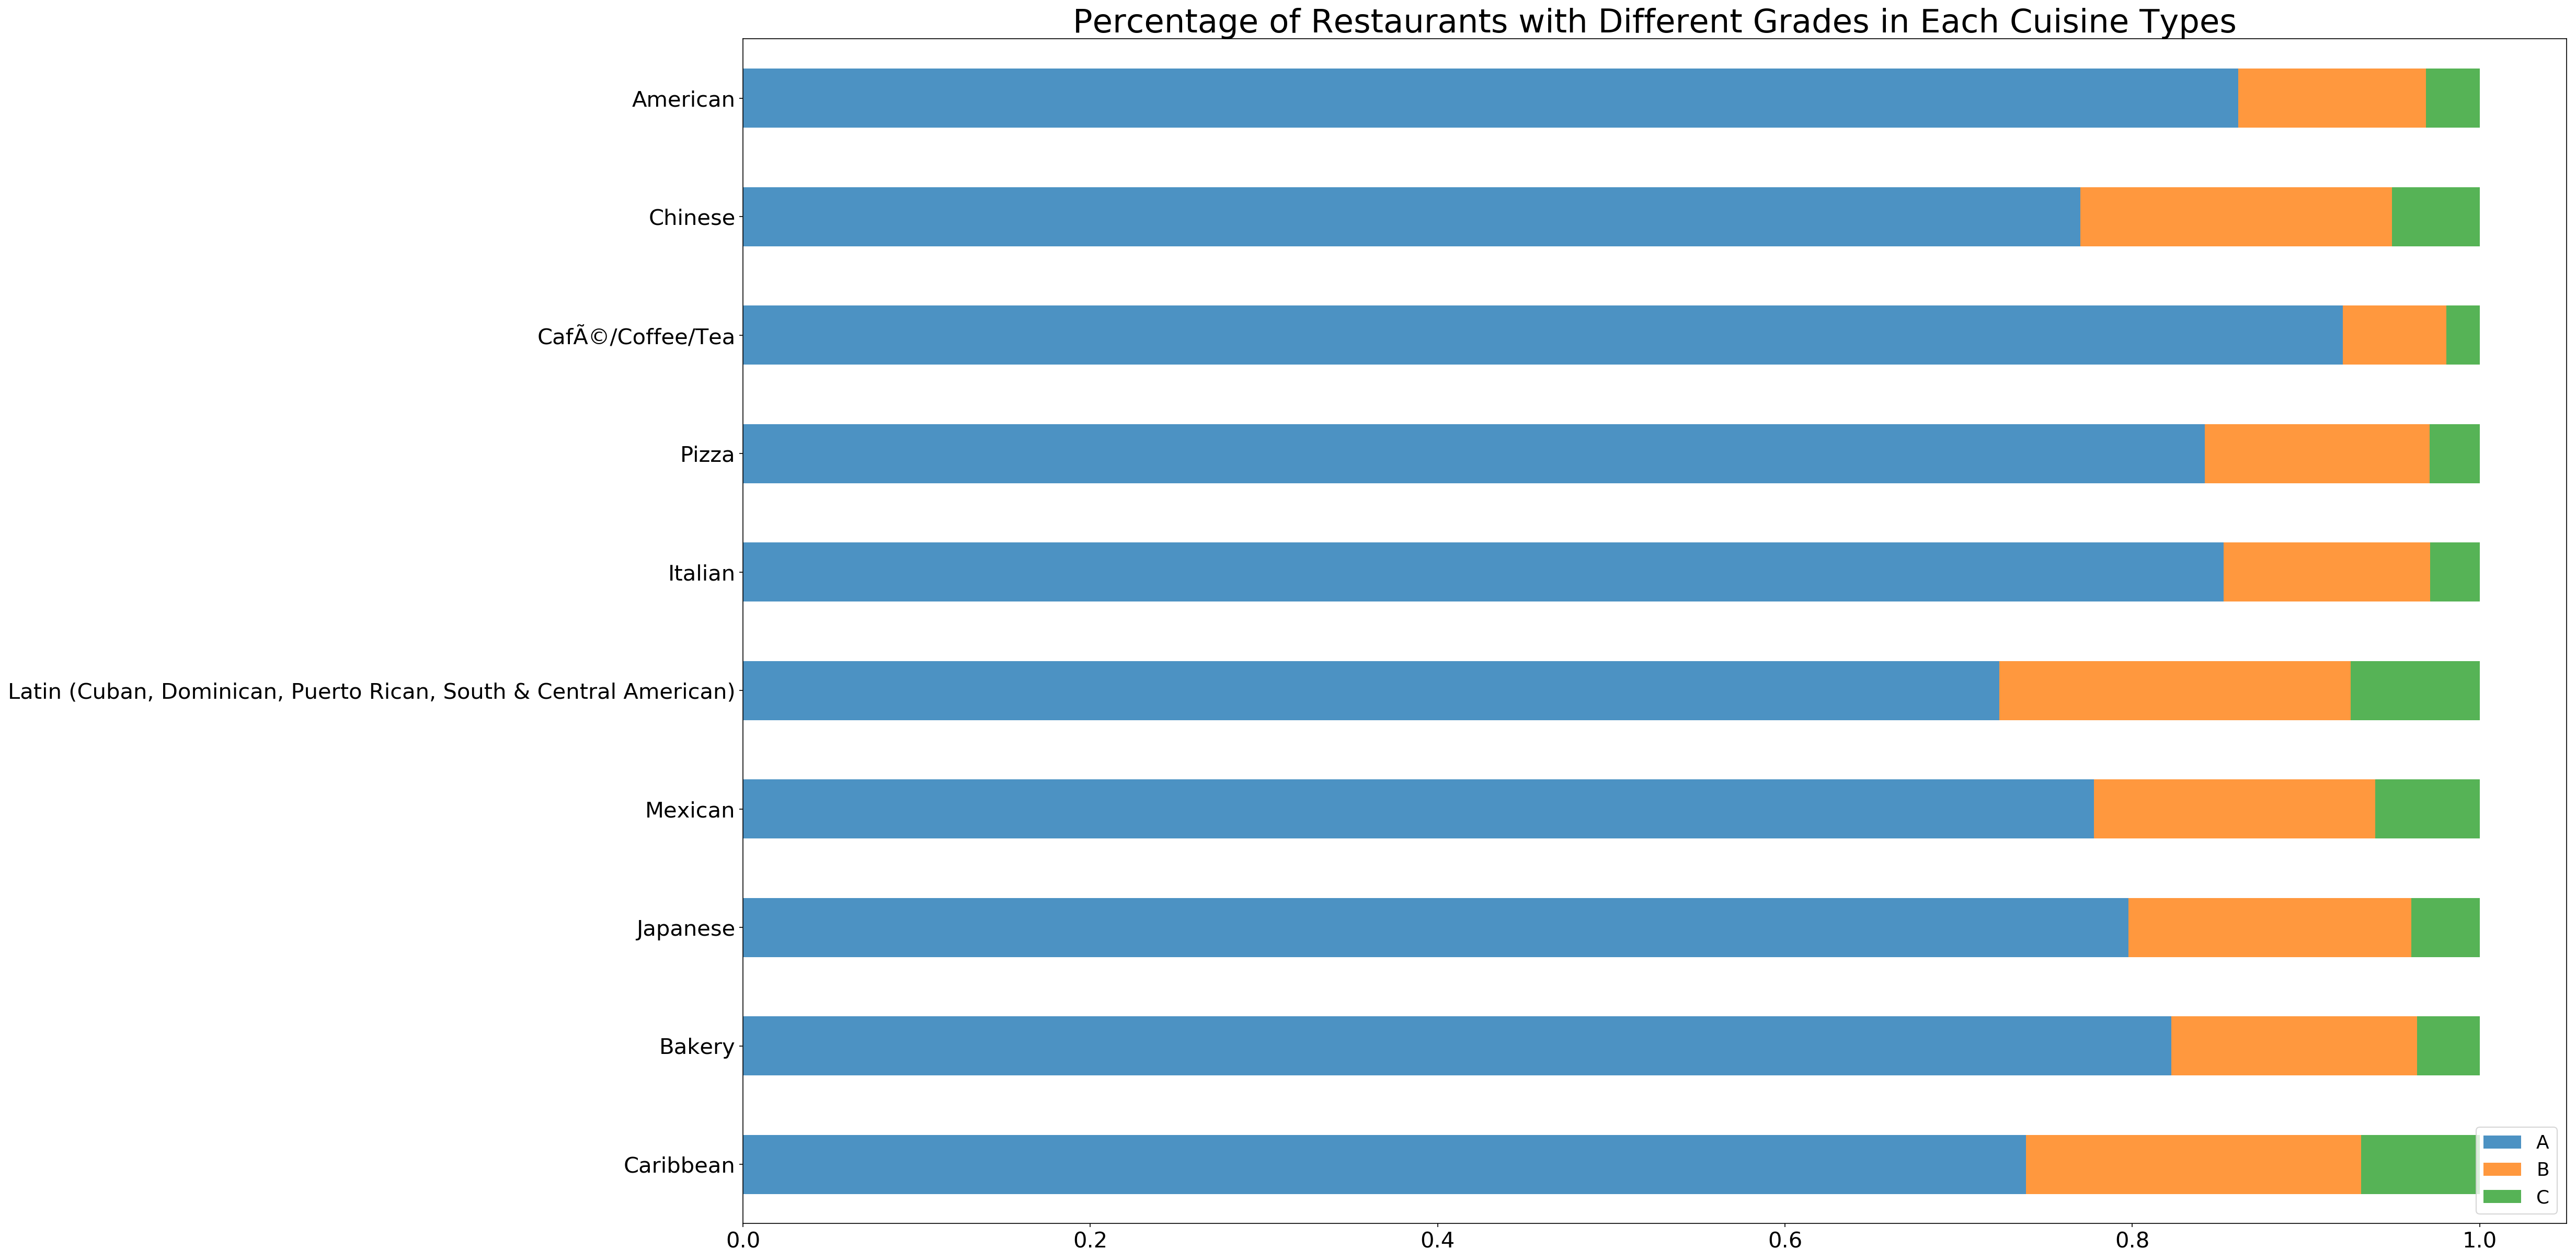

In [56]:
#Number of resturants in every grade groups against cuisine types
fig, ax = plt.subplots(figsize = (30,20), dpi=150)
cuisinegrade_T_.iloc[:10,:3].plot.barh(ax=ax, alpha = 0.8, rot=0,align='center',fontsize=20,legend=True, stacked = True)
ax.invert_yaxis()
ax.legend(fontsize='xx-large', loc=4)

plt.title('Percentage of Restaurants with Different Grades in Each Cuisine Types', size=30)

In [57]:
score_ = inspect[['SCORE']].groupby(inspect['ZIPCODE']).mean()

In [58]:
geoscore = nycshape.merge(score_, right_on = score_.index, left_on = 'ZIPCODE')

ValueError: You are trying to merge on object and float64 columns. If you wish to proceed you should use pd.concat

NameError: name 'geoscore' is not defined

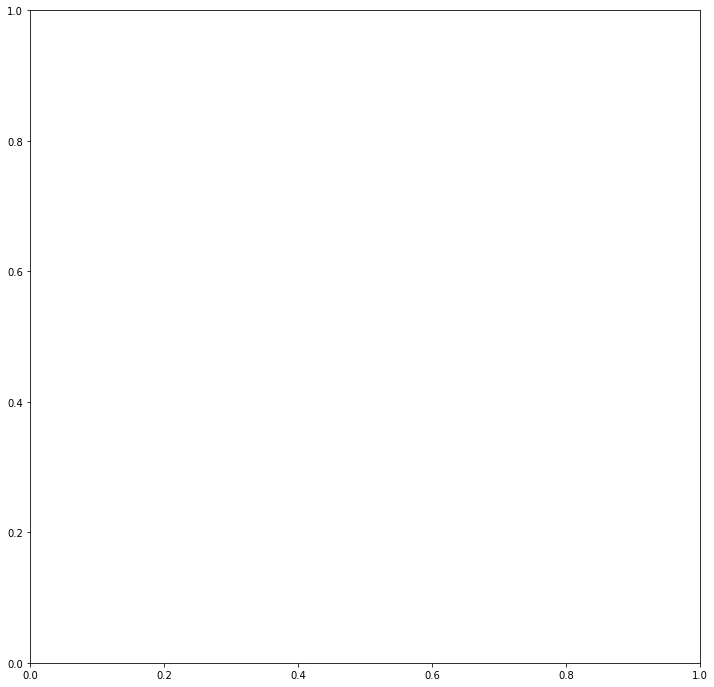

In [60]:
f,ax=pl.subplots(figsize=(12,12))
geoscore.plot(ax=ax, column = 'SCORE', cmap="PuBu", edgecolor = 'black', categorical = True, legend = False, alpha = 0.7 )

In [61]:
kinspect = inspect[['ZIPCODE','SCORE']]

In [62]:
kinspect.head()

,ZIPCODE,SCORE
0,11209.0,13.0
1,11230.0,27.0
2,10475.0,30.0
3,10033.0,12.0
4,11373.0,19.0


In [63]:
kinspect = kinspect[['SCORE']].groupby(kinspect['ZIPCODE']).mean()

In [64]:
km = KMeans(n_clusters=8, random_state=145).fit(kinspect)

In [65]:
centroids = km.cluster_centers_
centroids.shape

(8, 1)

In [66]:
kinspect['cluster'] = km.labels_

In [67]:
kinspect.head()

,SCORE,cluster
ZIPCODE,,
10000.0,16.666667,5
10001.0,19.539930,0
10002.0,21.105695,7
10003.0,19.707265,0
10004.0,18.193002,2


In [68]:
nycshape.ZIPCODE = nycshape.ZIPCODE.astype(float)

In [69]:
geoinspect = nycshape.merge(kinspect, right_on = 'ZIPCODE', left_on = 'ZIPCODE')

In [70]:
geoinspect = geoinspect.set_index('ZIPCODE')

In [71]:
geoinspect.shape

(231, 14)

In [72]:
for i in range(0,8):
    print (kinspect[kinspect['cluster'] == i].mean())
    print (len(kinspect[kinspect['cluster'] == i]))

SCORE      19.767575
cluster     0.000000
dtype: float64
65
SCORE      11.965877
cluster     1.000000
dtype: float64
13
SCORE      18.124053
cluster     2.000000
dtype: float64
65
SCORE      34.688034
cluster     3.000000
dtype: float64
2
SCORE      7.722006
cluster    4.000000
dtype: float64
12
SCORE      15.817613
cluster     5.000000
dtype: float64
25
SCORE      26.306988
cluster     6.000000
dtype: float64
2
SCORE      21.506871
cluster     7.000000
dtype: float64
39


In [73]:
kinspect.head()

,SCORE,cluster
ZIPCODE,,
10000.0,16.666667,5
10001.0,19.539930,0
10002.0,21.105695,7
10003.0,19.707265,0
10004.0,18.193002,2


In [74]:
centroids

array([[19.76757544],
       [11.96587689],
       [18.12405258],
       [34.68803419],
       [ 7.72200577],
       [15.81761343],
       [26.30698779],
       [21.50687125]])

In [75]:
old = np.zeros(8)
for i in range(8):
    old[i] = centroids[i]
old = old.argsort()
new = np.arange(8)

In [76]:
kinspect['cluster'] = kinspect['cluster'].replace(old.tolist(), new.tolist())

In [77]:
kinspect.head()

,SCORE,cluster
ZIPCODE,,
10000.0,16.666667,2
10001.0,19.539930,4
10002.0,21.105695,5
10003.0,19.707265,4
10004.0,18.193002,3


Text(0.5, 1.0, 'Violation Scores of Resturants with 8 clusters agaisnt Zip Code')

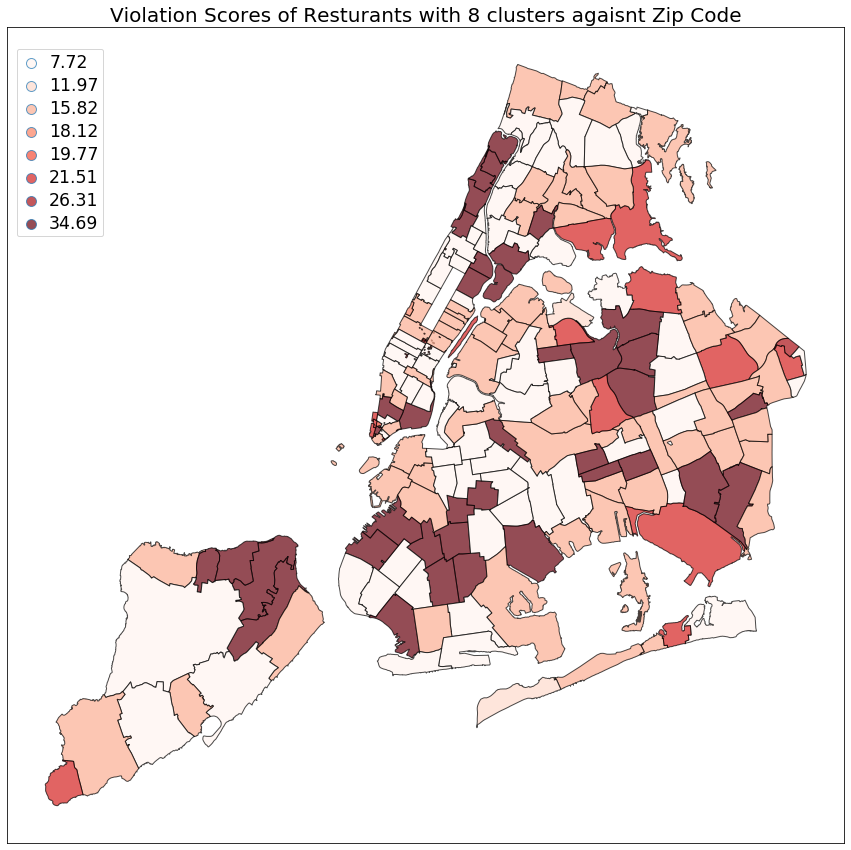

In [78]:
fig,ax = pl.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
geoinspect.plot(ax=ax, column = 'cluster', cmap="Reds", edgecolor = 'black', 
            categorical = True, legend = True, alpha = 0.7 )
leg = ax.get_legend()
for i in range(8):
    leg.get_texts()[i].set_text(round(kinspect[kinspect['cluster'] == i].mean()[0],2))
leg.set_bbox_to_anchor((0.12,0.98))
for text in leg.get_texts():
    text.set_fontsize('xx-large')
    
plt.title('Violation Scores of Resturants with 8 clusters agaisnt Zip Code', size=20)

In [79]:
inspect[inspect['BORO'] == 'BROOKLYN']['SCORE'].mean()

20.07814183617372

**Inspection Time Pattern**

**Time Series**
- R numbers changes yearly? grade inflation?
- inspection time has seasonality?

In [80]:
inspect.head()

,BORO,ZIPCODE,CUISINE DESCRIPTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION DATE
0,BROOKLYN,11209.0,CafÃ©/Coffee/Tea,10F,Not Critical,13.0,A,08/07/2018
1,BROOKLYN,11230.0,Indian,04L,Critical,27.0,N,03/27/2018
2,BRONX,10475.0,Delicatessen,04N,Critical,30.0,N,11/05/2018
3,MANHATTAN,10033.0,Spanish,08A,Not Critical,12.0,A,06/08/2017
4,QUEENS,11373.0,Irish,10B,Not Critical,19.0,B,07/12/2018


In [129]:
inspect['date'] = pd.to_datetime(inspect['INSPECTION DATE'])

In [130]:
inspect['year'], inspect['month'] = inspect['date'].apply(lambda x: x.year),inspect['date'].apply(lambda x: x.month)

In [131]:
inspect.dropna(inplace=True)

In [132]:
inspect.head()

,BORO,ZIPCODE,CUISINE DESCRIPTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION DATE,date,year,month
0,BROOKLYN,11209.0,CafÃ©/Coffee/Tea,10F,Not Critical,13.0,A,08/07/2018,2018-08-07,2018,8
1,BROOKLYN,11230.0,Indian,04L,Critical,27.0,N,03/27/2018,2018-03-27,2018,3
2,BRONX,10475.0,Delicatessen,04N,Critical,30.0,N,11/05/2018,2018-11-05,2018,11
3,MANHATTAN,10033.0,Spanish,08A,Not Critical,12.0,A,06/08/2017,2017-06-08,2017,6
4,QUEENS,11373.0,Irish,10B,Not Critical,19.0,B,07/12/2018,2018-07-12,2018,7


In [85]:
y18 = inspect[inspect['year']==2018].groupby('GRADE').count()[['BORO']].T.rename({'BORO':'2018'})
y17 = inspect[inspect['year']==2017].groupby('GRADE').count()[['BORO']].T.rename({'BORO':'2017'})
y16 = inspect[inspect['year']==2016].groupby('GRADE').count()[['BORO']].T.rename({'BORO':'2016'})
y15 = inspect[inspect['year']==2015].groupby('GRADE').count()[['BORO']].T.rename({'BORO':'2015'})
yearG=[y15,y16,y17,y18]
yearG=pd.concat(yearG)

/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [86]:
yearG.drop('N',axis=1, inplace=True)

In [87]:
yearG.drop('Not Yet Graded',axis=1, inplace=True)

In [88]:
yearG.drop('P',axis=1, inplace=True)

In [89]:
yearG.drop('Z',axis=1, inplace=True)

In [90]:
yearG.drop('G',axis=1, inplace=True)

In [91]:
year18 = inspect[inspect['year'] == 2018].groupby('GRADE').count()[['BORO']]

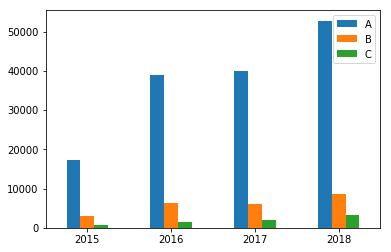

In [92]:
yearG.plot(kind = 'bar', rot=0)

In [93]:
yearG_ = yearG/yearG.sum(axis=0)

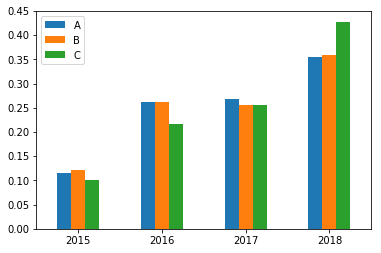

In [94]:
yearG_.plot(kind = 'bar', rot=0) #normalized the dataset

No grade inflation

In [95]:
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator

Text(0, 0.5, 'Number of Inspections')

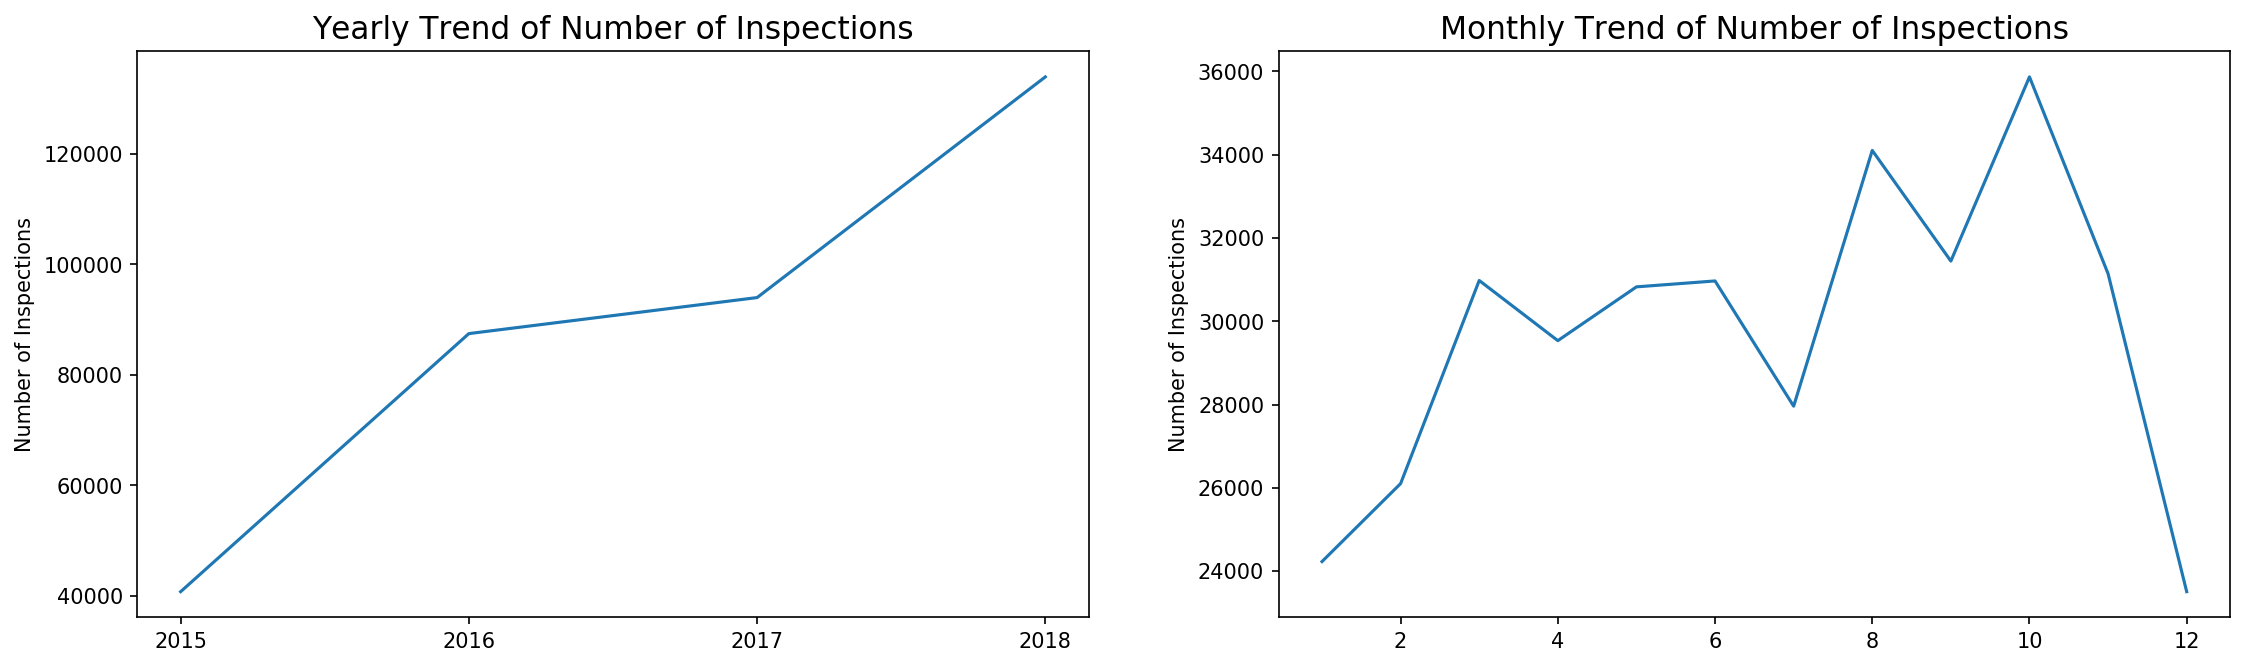

In [96]:
fig,ax = pl.subplots(1,2,figsize =(18,5),dpi=150)
ax[0].plot(inspect.groupby('year').count()[['BORO']].iloc[-4:])
ax[1].plot(inspect.groupby('month').count()[['BORO']])


ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_title('Yearly Trend of Number of Inspections', size=15)
ax[0].set_ylabel('Number of Inspections')

ax[1].set_title('Monthly Trend of Number of Inspections', size=15)
ax[1].set_ylabel('Number of Inspections')




In [97]:
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma

In [98]:
cycle, trend = sma.tsa.filters.hpfilter(yearG, lamb = 6.25)

Text(0, 0.5, 'Number of Inspections')

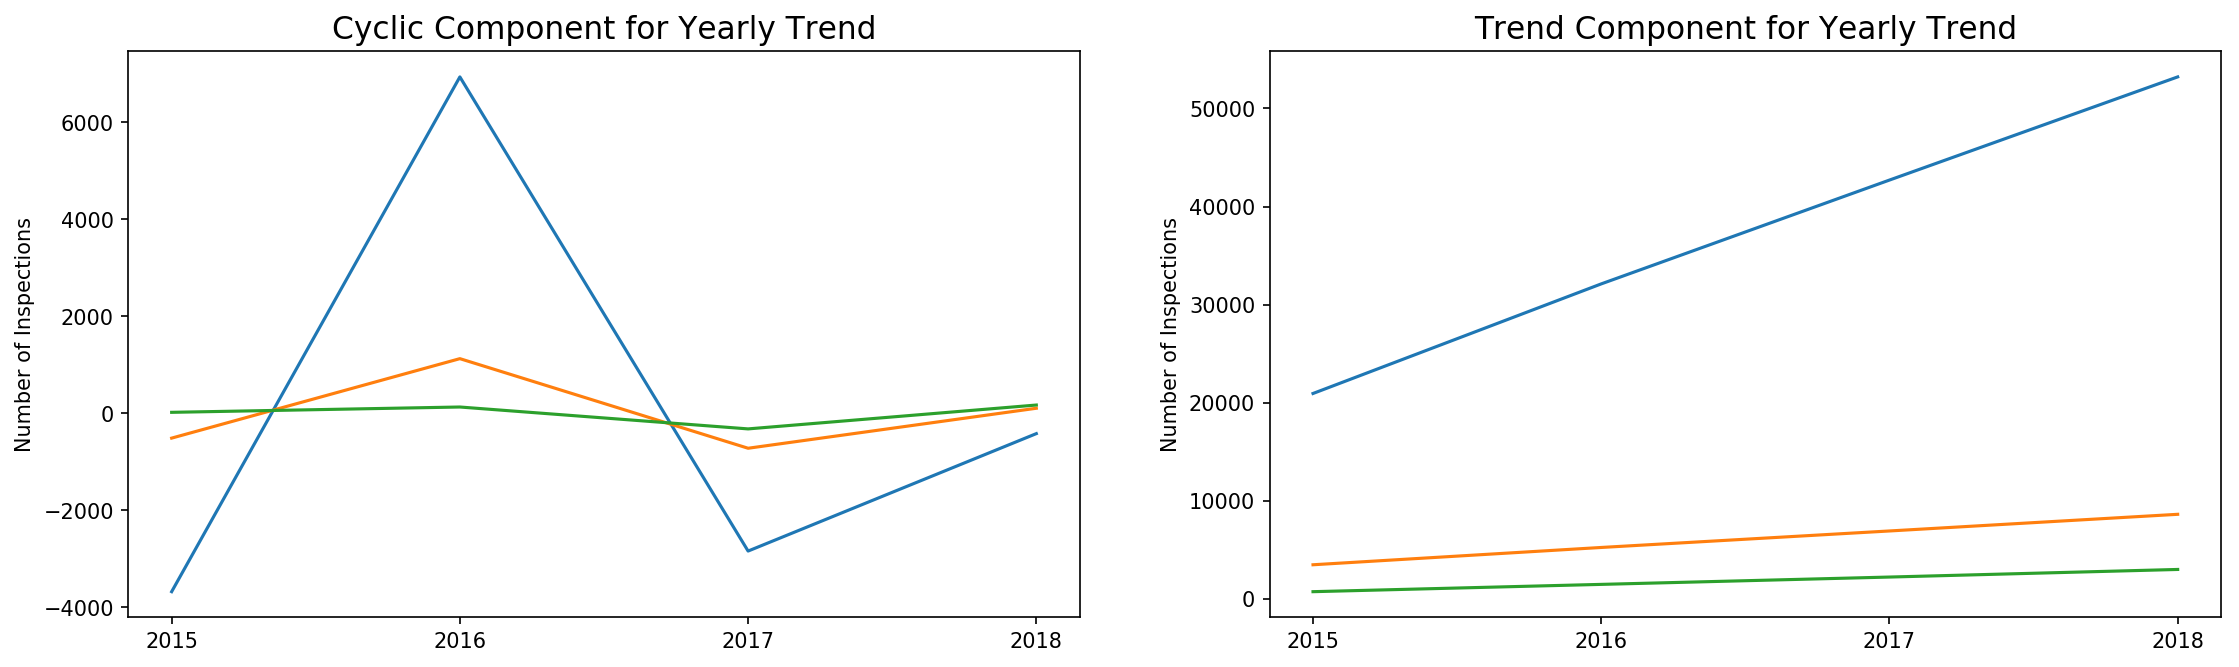

In [99]:
fig,ax = pl.subplots(1,2,figsize =(18,5),dpi=150)
ax[0].plot(cycle)
ax[1].plot(trend)


ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_title('Cyclic Component for Yearly Trend', size=15)
ax[0].set_ylabel('Number of Inspections')

ax[1].set_title('Trend Component for Yearly Trend', size=15)
ax[1].set_ylabel('Number of Inspections')



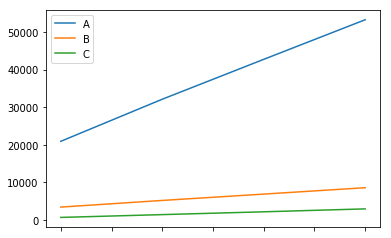

In [100]:
trend.plot()

In [101]:
y18 = inspect[inspect['']==2018].groupby('GRADE').count()[['BORO']].T.rename({'BORO':'2018'})
y17 = inspect[inspect['year']==2017].groupby('GRADE').count()[['BORO']].T.rename({'BORO':'2017'})
y16 = inspect[inspect['year']==2016].groupby('GRADE').count()[['BORO']].T.rename({'BORO':'2016'})
y15 = inspect[inspect['year']==2015].groupby('GRADE').count()[['BORO']].T.rename({'BORO':'2015'})
yearG=[y15,y16,y17,y18]
yearG=pd.concat(yearG)

KeyError: ''

In [103]:
mA = inspect[inspect['GRADE']== 'A'].groupby('month').count()[['BORO']].T.rename({'BORO':'A'})
mB = inspect[inspect['GRADE']== 'B'].groupby('month').count()[['BORO']].T.rename({'BORO':'B'})
mC = inspect[inspect['GRADE']== 'C'].groupby('month').count()[['BORO']].T.rename({'BORO':'C'})

In [104]:
tmp = [mA, mB, mC]
tmp =pd.concat(tmp)

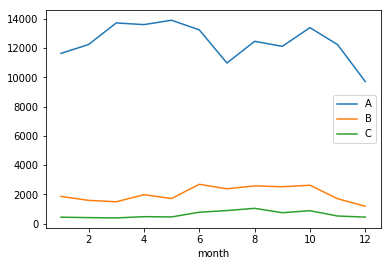

In [105]:
tmp.T.plot()

In [106]:
cycle, trend = sma.tsa.filters.hpfilter(tmp.T, lamb = 6.25)

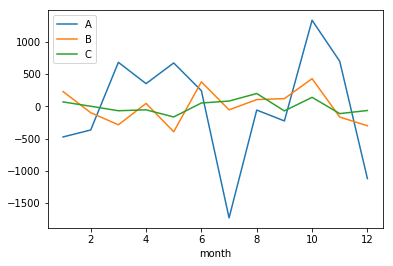

In [107]:
cycle.plot()

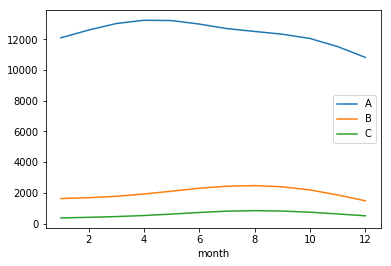

In [108]:
trend.plot()

Text(0, 0.5, 'Number of Inspections')

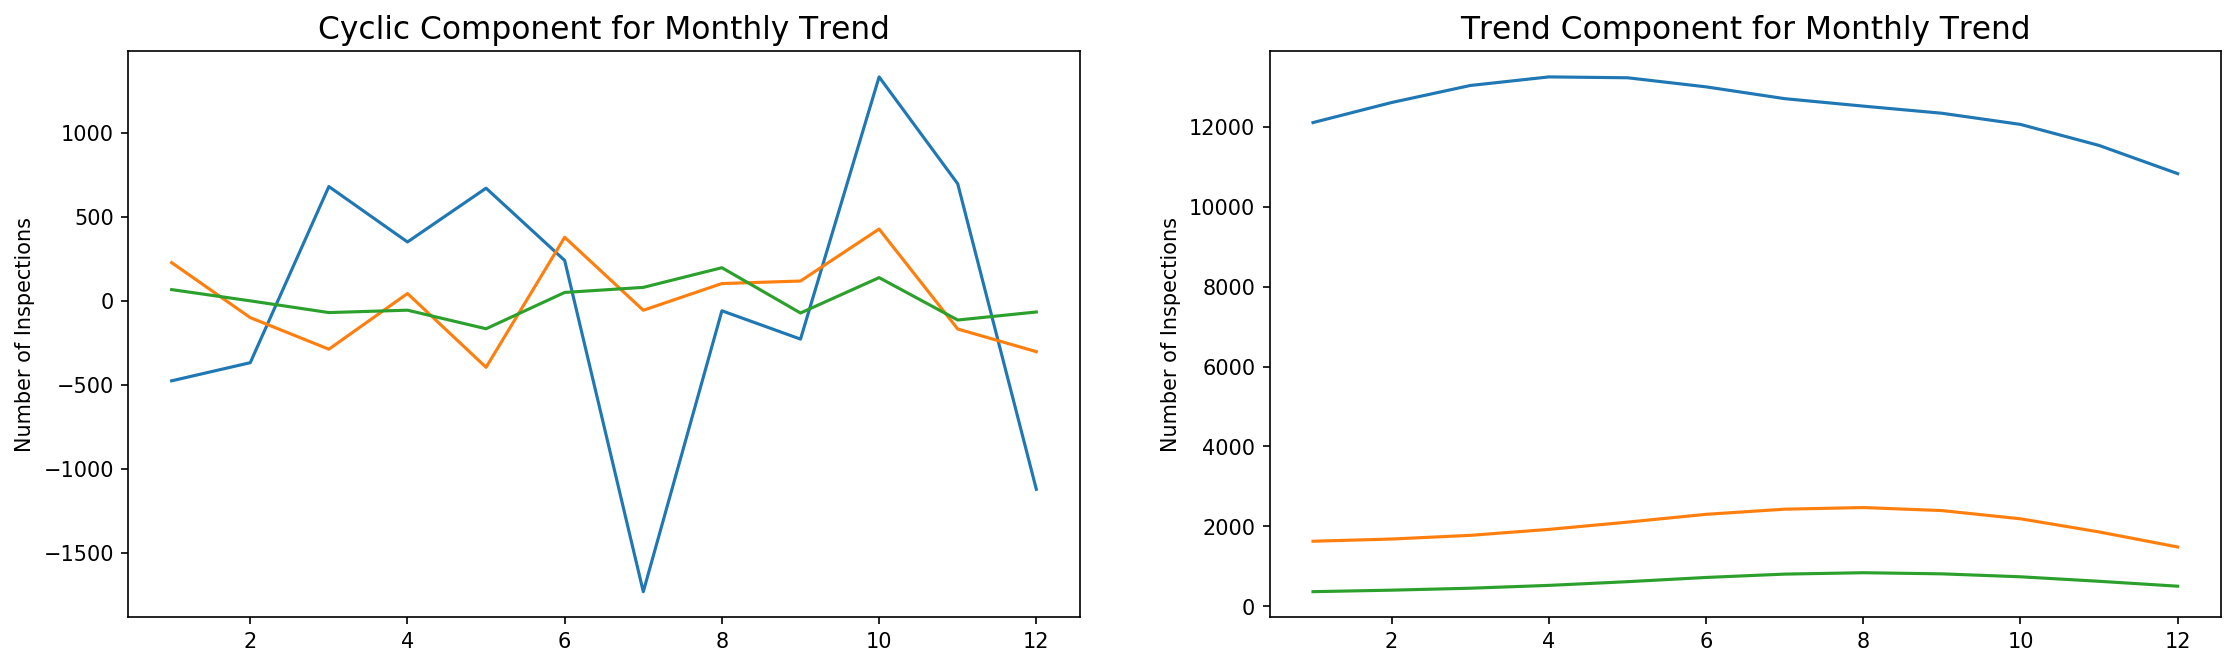

In [109]:
fig,ax = pl.subplots(1,2,figsize =(18,5),dpi=150)
ax[0].plot(cycle)
ax[1].plot(trend)


ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_title('Cyclic Component for Monthly Trend', size=15)
ax[0].set_ylabel('Number of Inspections')


ax[1].set_title('Trend Component for Monthly Trend', size=15)
ax[1].set_ylabel('Number of Inspections')



In [110]:
inspect['VIOLATION CODE'].apply(pd.value_counts).head(15)

KeyboardInterrupt: 

In [ ]:
inspect[inspect['CUISINE DESCRIPTION'] == 'Japanese']['VIOLATION CODE'].apply(pd.value_counts).head(10)

In [ ]:
violation = inspect[['SCORE','VIOLATION CODE']]

In [ ]:
inspect

In [ ]:
import scipy.cluster as scp
fig = pl.figure(figsize=(10,25), dpi=150)
pl.xlabel("distance", fontsize =10)
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(violation, method ='str'),
                               labels = vals.index,
                               orientation = "left",
                               leaf_font_size=7.) 

In [121]:
inspect.head()

,BORO,ZIPCODE,CUISINE DESCRIPTION,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,INSPECTION DATE
0,BROOKLYN,11209.0,CafÃ©/Coffee/Tea,10F,Not Critical,13.0,A,08/07/2018
1,BROOKLYN,11230.0,Indian,04L,Critical,27.0,N,03/27/2018
2,BRONX,10475.0,Delicatessen,04N,Critical,30.0,N,11/05/2018
3,MANHATTAN,10033.0,Spanish,08A,Not Critical,12.0,A,06/08/2017
4,QUEENS,11373.0,Irish,10B,Not Critical,19.0,B,07/12/2018


In [134]:
newtem = geoinspect.merge(inspect, left_on = geoinspect.index, right_on = inspect['ZIPCODE'])

In [135]:
newtem.columns

Index(['key_0', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE', 'COUNTY',
       'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry',
       'SCORE_x', 'cluster', 'BORO', 'ZIPCODE', 'CUISINE DESCRIPTION',
       'VIOLATION CODE', 'CRITICAL FLAG', 'SCORE_y', 'GRADE',
       'INSPECTION DATE', 'date', 'year', 'month'],
      dtype='object')

In [155]:
X=newtem[[ 'year','month','POPULATION','cluster']]
X = sm.add_constant(X)

In [156]:
y = newtem['SCORE_x']

In [157]:
mod =sm.OLS(y, X).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                SCORE_x   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                 3.962e+04
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        23:28:59   Log-Likelihood:            -5.9611e+05
No. Observations:              369291   AIC:                         1.192e+06
Df Residuals:                  369286   BIC:                         1.192e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.1134      3.921    -12.780      0.0